### **Step 1: Setting Up the Environment**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=4364c99587cf9fd2b634ee084ecd05d8181bd81b5aec95eb6c9756e09d839ace
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Google Ads Optimization") \
    .getOrCreate()


### **Step 2: Loading the Dataset**

In [6]:
# Load the dataset
data_path = "/content/50krecords.csv"  # Update this path to where your dataset is located
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Display the schema
df.printSchema()

# Show a sample of the data
df.show(5)


root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: timestamp (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)

+--------------------+-----+------------

Explanation:

We read the CSV file using spark.read.csv() with header=True and inferSchema=True to automatically infer data types.
The printSchema() method displays the structure of the DataFrame.
The show(5) method displays the first five rows.

### **Step 3: Data Preprocessing**

In [7]:
# Check for missing values
from pyspark.sql.functions import col, sum

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

# Drop rows with missing values (if any)
df = df.dropna()

# Convert 'hour' column to timestamp
df = df.withColumn('hour', to_timestamp(col('hour'), 'yyyy-MM-dd HH:mm:ss'))

# Extract 'hour_of_day' and 'day_of_week'
df = df.withColumn('hour_of_day', hour(col('hour')))
df = df.withColumn('day_of_week', date_format(col('hour'), 'E'))

# Convert 'click' column to integer type
df = df.withColumn('click', col('click').cast('integer'))


+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
| id|click|hour| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
|  0|    0|   0|  0|         0|      0|          0|            0|     0|         0|           0|        0|        0|           0|          0|               0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+



Explanation:

- Check for and handle missing values.
- Convert the hour column to a timestamp.
- Extract time-based features like hour_of_day and day_of_week.
- Ensure the click column is of integer type for modeling.

### **Step 4: Exploratory Data Analysis (EDA)**

#### 4.1 Analyzing Click-Through Rate (CTR)

In [8]:
# Calculate CTR
total_clicks = df.filter(col('click') == 1).count()
total_impressions = df.count()
ctr = (total_clicks / total_impressions) * 100
print(f"Click-Through Rate (CTR): {ctr:.2f}%")


Click-Through Rate (CTR): 16.93%


#### 4.2 Visualizing CTR by Hour of Day

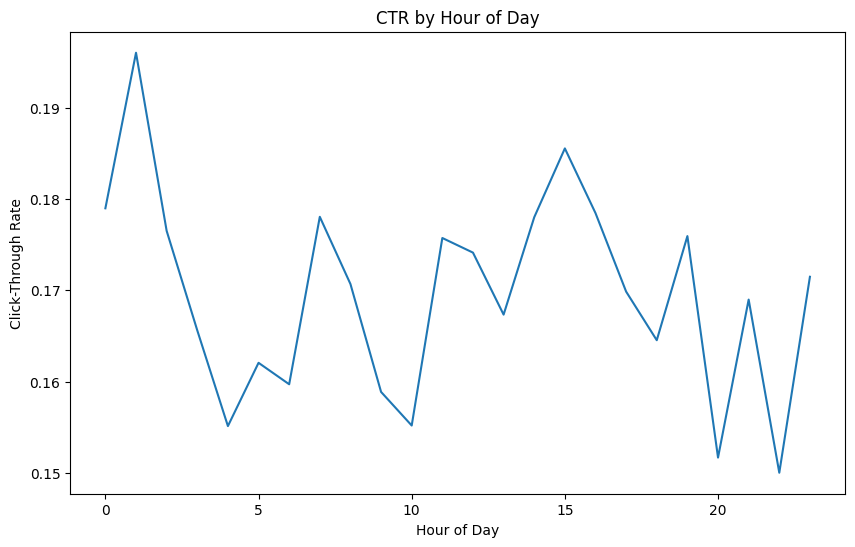

In [9]:
# Aggregate clicks by hour_of_day
ctr_by_hour = df.groupBy('hour_of_day').agg(
    (sum(col('click')) / count(col('click'))).alias('ctr')
).orderBy('hour_of_day')

# Convert to Pandas for plotting
ctr_by_hour_pd = ctr_by_hour.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=ctr_by_hour_pd, x='hour_of_day', y='ctr')
plt.title('CTR by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Click-Through Rate')
plt.show()


### **Step 5: Feature Engineering**

#### 5.1 Encoding Categorical Variables

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# List of categorical columns to encode
categorical_cols = ['C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type']

# Indexing and Encoding stages
stages = []
for col_name in categorical_cols:
    string_indexer = StringIndexer(inputCol=col_name, outputCol=col_name + '_Index')
    # Set dropLast=False to include all categories
    encoder = OneHotEncoder(inputCol=col_name + '_Index', outputCol=col_name + '_Vec', dropLast=False)
    stages += [string_indexer, encoder]

# Build and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)


Explanation:

- Encode categorical variables using StringIndexer and OneHotEncoder.
- Set dropLast=False to include all categories, which is important for feature mapping later.

### **5.2 Assembling Features**

In [11]:
from pyspark.ml.feature import VectorAssembler

# List of feature columns
feature_cols = [col + '_Vec' for col in categorical_cols] + ['hour_of_day']

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)


Explanation:

Combine all feature columns into a single feature vector using `VectorAssembler`.


### **Step 6: Feature Selection**

#### 6.1 Apply Chi-Squared Feature Selection

In [12]:
from pyspark.ml.feature import ChiSqSelector

# Initialize ChiSqSelector
selector = ChiSqSelector(numTopFeatures=50, featuresCol='features', labelCol='click', outputCol='selectedFeatures')

# Fit the selector to the data
selector_model = selector.fit(df)

# Transform the data
df = selector_model.transform(df)


Explanation:

Use Chi-Squared test to select the top 50 features that are most relevant to predicting clicks.

### **Step 7: Handling Class Imbalance**
#### 7.1 Calculate Class Weights

In [13]:
# Calculate the ratio of the positive class
num_positive = df.filter(df.click == 1).count()
num_negative = df.filter(df.click == 0).count()
balancing_ratio = num_negative / num_positive

print(f"Balancing Ratio: {balancing_ratio:.2f}")


Balancing Ratio: 4.91


#### 7.2 Add Class Weights to Data

In [14]:
# Add a weight column
df = df.withColumn("classWeightCol", when(df.click == 1, balancing_ratio).otherwise(1.0))


Explanation:

Calculate the balancing ratio and adjust for class imbalance by adding a `classWeightCol`.

### **Step 8: Model Training with Gradient Boosted Trees**
#### 8.1 Split the Data

In [15]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


#### 8.2 Initialize and Train the Model

In [16]:
from pyspark.ml.classification import GBTClassifier

# Initialize the Gradient Boosted Trees Classifier
gbt = GBTClassifier(featuresCol='selectedFeatures', labelCol='click', weightCol='classWeightCol', maxIter=20)

# Train the model
gbt_model = gbt.fit(train_df)


Explanation:

- Use Gradient Boosted Trees with class weights to train the model on the training data.

### **Step 9: Hyperparameter Tuning**
#### 9.1 Set Up Hyperparameter Grid

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='click', metricName='areaUnderROC')

# Create parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .build()


#### 9.2 Cross-Validation

In [18]:
# Set up CrossValidator
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)  # 3-fold cross-validation

# Run cross-validation and choose the best set of parameters
cv_model = cv.fit(train_df)

# Get the best model
best_model = cv_model.bestModel


Explanation:

Perform hyperparameter tuning using cross-validation to find the best model parameters.

 ### **Step 10: Model Evaluation**
#### 10.1 Evaluate the Best Model

In [19]:
# Make predictions on the test data
predictions = best_model.transform(test_df)

# Evaluate using AUC
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.4f}")


Test AUC: 0.6405


#### 10.2 Additional Metrics

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='click', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='click', predictionCol='prediction', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)
print(f"Test Precision: {precision:.4f}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='click', predictionCol='prediction', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)
print(f"Test Recall: {recall:.4f}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol='click', predictionCol='prediction', metricName='f1')
f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.5698
Test Precision: 0.7756
Test Recall: 0.5698
Test F1 Score: 0.6206


Explanation:

- Evaluate the model using various metrics to get a comprehensive understanding of its performance.

### **Step 11: Advanced Visualization**
#### 11.1 Interactive Feature Importance with Plotly

In [21]:
# Extract feature importances
importances = best_model.featureImportances

# Map feature importances to feature names
selected_features_indices = selector_model.selectedFeatures
feature_importance_list = []

for idx, importance in enumerate(importances):
    feature_idx = selected_features_indices[idx]
    # Handle the case when 'hour_of_day' is in the features
    if feature_idx < len(feature_cols):
        feature_name = feature_cols[feature_idx]
    else:
        feature_name = f"Feature_{feature_idx}"
    feature_importance_list.append((feature_name, importance))

# Convert to DataFrame
importance_df = pd.DataFrame(feature_importance_list, columns=['feature', 'importance'])
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Plot using Plotly
fig = px.bar(importance_df.head(20), x='importance', y='feature', orientation='h', title='Top 20 Feature Importances')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


Explanation:

- Use `Plotly` to create an interactive bar chart of the top 20 feature importances.


### **Step 12: Saving and Loading Models**
#### 12.1 Save the Best Model

In [25]:
# Save the best model to the Colab VM file system
model_save_path = "/content/best_gbt_model"
best_model.save(model_save_path)

In [26]:
!zip -r best_gbt_model.zip /content/best_gbt_model

  adding: content/best_gbt_model/ (stored 0%)
  adding: content/best_gbt_model/data/ (stored 0%)
  adding: content/best_gbt_model/data/.part-00000-69600d60-49b4-4ace-b550-c7033882cad6-c000.snappy.parquet.crc (stored 0%)
  adding: content/best_gbt_model/data/._SUCCESS.crc (stored 0%)
  adding: content/best_gbt_model/data/_SUCCESS (stored 0%)
  adding: content/best_gbt_model/data/part-00000-69600d60-49b4-4ace-b550-c7033882cad6-c000.snappy.parquet (deflated 13%)
  adding: content/best_gbt_model/treesMetadata/ (stored 0%)
  adding: content/best_gbt_model/treesMetadata/._SUCCESS.crc (stored 0%)
  adding: content/best_gbt_model/treesMetadata/.part-00000-82c2ad59-b87c-4aa4-b59c-309870951729-c000.snappy.parquet.crc (stored 0%)
  adding: content/best_gbt_model/treesMetadata/_SUCCESS (stored 0%)
  adding: content/best_gbt_model/treesMetadata/part-00000-82c2ad59-b87c-4aa4-b59c-309870951729-c000.snappy.parquet (deflated 40%)
  adding: content/best_gbt_model/metadata/ (stored 0%)
  adding: content/

In [27]:
from google.colab import files
files.download('best_gbt_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 12.2 Load the Saved Model

In [28]:
from pyspark.ml.classification import GBTClassificationModel

# Load the model
loaded_model = GBTClassificationModel.load(model_save_path)


Explanation:

Save the trained model for future use and load it when needed.


### **Step 13: Building a Simple Recommender for Bidding Strategy**
#### 13.1 Recommend Bid Adjustments Based on Predicted Probabilities

In [29]:
# Define a function to recommend bid adjustments
def recommend_bid(probability):
    prob = probability[1]  # Probability of class 1 (click)
    if prob >= 0.8:
        return 'Increase bid by 20%'
    elif prob >= 0.6:
        return 'Increase bid by 10%'
    elif prob >= 0.4:
        return 'Maintain current bid'
    else:
        return 'Decrease bid by 10%'

# Register UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

recommend_bid_udf = udf(recommend_bid, StringType())

# Apply the UDF to get bid recommendations
predictions = predictions.withColumn('bid_recommendation', recommend_bid_udf('probability'))

# Show some examples
predictions.select('probability', 'bid_recommendation').show(5, truncate=False)


+----------------------------------------+--------------------+
|probability                             |bid_recommendation  |
+----------------------------------------+--------------------+
|[0.45638854422668457,0.5436114557733154]|Maintain current bid|
|[0.4422460289489644,0.5577539710510355] |Maintain current bid|
|[0.5905618689745546,0.40943813102544535]|Maintain current bid|
|[0.44263645771645826,0.5573635422835417]|Maintain current bid|
|[0.38700928323989353,0.6129907167601065]|Increase bid by 10% |
+----------------------------------------+--------------------+
only showing top 5 rows



Explanation:

Create a user-defined function to recommend bid adjustments based on predicted click probabilities.
